# Example-42: Tune (Tune spread from quafrupole errors)

In [1]:
# Import

from random import random
from pprint import pprint

import torch
from torch import Tensor

from pathlib import Path

import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['text.usetex'] = True

from model.library.line import Line

from model.command.external import load_sdds
from model.command.external import load_lattice
from model.command.build import build
from model.command.tune import tune

In [2]:
# Load ELEGANT twiss

path = Path('ic.twiss')
parameters, columns = load_sdds(path)

nu_qx:Tensor = torch.tensor(parameters['nux'] % 1, dtype=torch.float64)
nu_qy:Tensor = torch.tensor(parameters['nuy'] % 1, dtype=torch.float64)

psi_qx:Tensor = torch.tensor(parameters['dnux/dp'], dtype=torch.float64)
psi_qy:Tensor = torch.tensor(parameters['dnuy/dp'], dtype=torch.float64)

In [3]:
# Build and setup lattice

# Note, sextupoles are turned off and dipoles are linear 

# Load ELEGANT table

path = Path('ic.lte')
data = load_lattice(path)

# Build ELEGANT table

ring:Line = build('RING', 'ELEGANT', data)
ring.flatten()

# Merge drifts

ring.merge()

# Turn off sextupoles and set linear dipoles

for element in ring: 
    if element.__class__.__name__ == 'Sextupole':
        element.ms = 0.0
    if element.__class__.__name__ == 'Dipole':
        element.linear = True

# Set number of elements of different kinds

nb = ring.describe['BPM']
nq = ring.describe['Quadrupole']
ns = ring.describe['Sextupole']

tensor(0.0012, dtype=torch.float64)
tensor(0.0008, dtype=torch.float64)



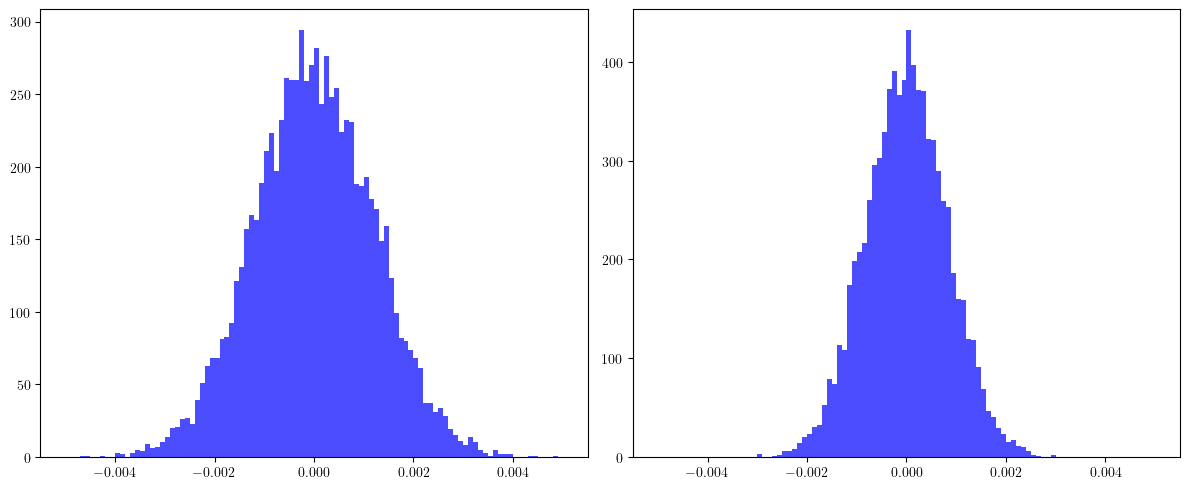

In [4]:
# Compute tune spread using MC

kns = 5.0E-3*torch.randn((8192, nq), dtype=torch.float64)

nuqx, nuqy = torch.vmap(lambda kn: tune(ring, [kn], ('kn', ['Quadrupole'], None, None), matched=True, limit=1, epsilon=None), chunk_size=1024)(kns).T

# Spread

print(nuqx.std(-1))
print(nuqy.std(-1))
print()

# Plot samples

fig, (ax, ay) = plt.subplots(1, 2, figsize=(12, 5))
ax.hist((nuqx - nuqx.mean()).cpu().numpy(), bins=100, range=(-5.0E-3, +5.0E-3), color='blue', alpha=0.7)
ay.hist((nuqy - nuqy.mean()).cpu().numpy(), bins=100, range=(-5.0E-3, +5.0E-3), color='blue', alpha=0.7)
plt.tight_layout() 
plt.show()

tensor(0.0012, dtype=torch.float64)
tensor(0.0008, dtype=torch.float64)



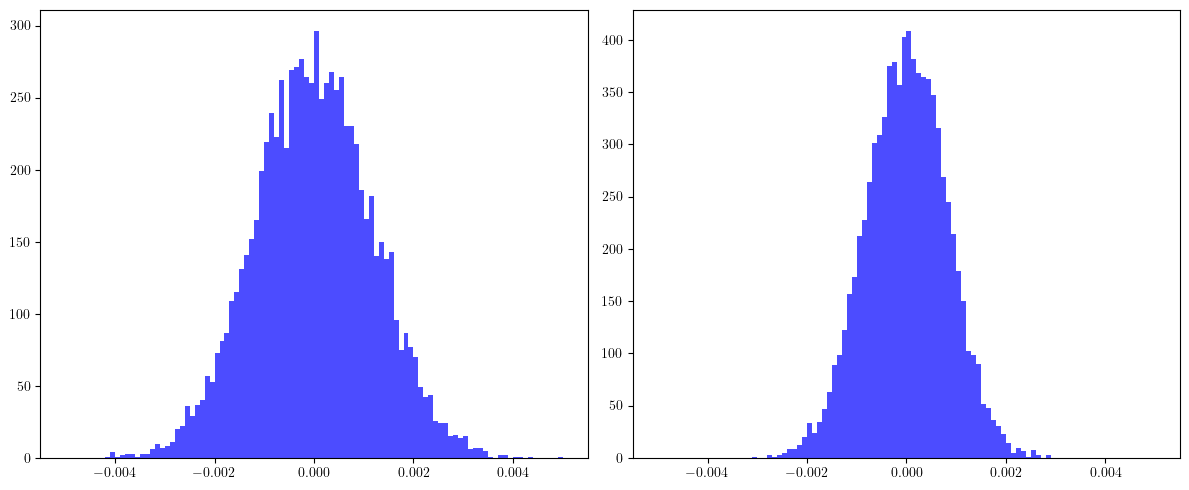

In [5]:
# Compute tune derivatives and estimate spread from linear surrogate model using MC

# Compute derivative

kn = torch.zeros(nq, dtype=torch.float64)
dnu_dk = torch.func.jacrev(lambda kn: tune(ring, [kn], ('kn', ['Quadrupole'], None, None), matched=True, limit=1, epsilon=None))(kn)

# Sample

kns = 5.0E-3*torch.randn((8192, nq), dtype=torch.float64)
nuqx, nuqy = dnu_dk @ kns.T

# Spread

print(nuqx.std(-1))
print(nuqy.std(-1))
print()

# Plot samples

fig, (ax, ay) = plt.subplots(1, 2, figsize=(12, 5))
ax.hist((nuqx - nuqx.mean()).cpu().numpy(), bins=100, range=(-5.0E-3, +5.0E-3), color='blue', alpha=0.7)
ay.hist((nuqy - nuqy.mean()).cpu().numpy(), bins=100, range=(-5.0E-3, +5.0E-3), color='blue', alpha=0.7)
plt.tight_layout() 
plt.show()

In [6]:
# Compute spread using error propagation

print((dnu_dk @ (5.0E-3*torch.eye(nq,  dtype=torch.float64))**2 @ dnu_dk.T).diag().sqrt())

tensor([0.0012, 0.0008], dtype=torch.float64)
